<a href="https://colab.research.google.com/github/shoiTK/deep_learning_with_pytorch/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning for comuter vision tutorial

In [ ]:
#import file
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [109]:
data_transforms = {
    'train': transforms.Compose([
         #切り抜きサイズの大きさ
         transforms.RandomResizedCrop(244),
         #ランダムに画像を反転させる
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         #RBGを平均と標準偏差で標準化する
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.244, 0.225])                       
    ]),
    'val': transforms.Compose([
         #画像の大きさを変更
         transforms.Resize(256),
         #画像の中心を切り抜く
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.244, 0.225])           
    ]),
}

data_dir = './drive/MyDrive/TransferLearning/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes, class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 244, 'val': 153} ['ants', 'bees']


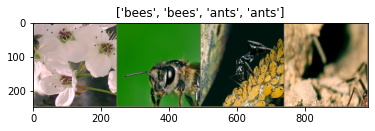

In [110]:
#４つのトレーニング画像を表示
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.299, 0.244, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [115]:
#modelを学習する
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch{}/{}'.format(epoch, num_epochs -1))
    print('-' * 10)

    #
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} ACC: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()

  time_elapsed = time.time() - since
  print('Training compete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [62]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)


In [112]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [116]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch0/9
----------
train Loss: 0.5088 ACC: 0.7869
val Loss: 0.1762 ACC: 0.9412

Epoch1/9
----------
train Loss: 0.4868 ACC: 0.7951
val Loss: 0.1742 ACC: 0.9346

Epoch2/9
----------
train Loss: 0.4002 ACC: 0.8238
val Loss: 0.3304 ACC: 0.8889

Epoch3/9
----------
train Loss: 0.4303 ACC: 0.8402
val Loss: 0.2943 ACC: 0.8824

Epoch4/9
----------
train Loss: 0.5127 ACC: 0.8197
val Loss: 0.5200 ACC: 0.8235

Epoch5/9
----------
train Loss: 0.4763 ACC: 0.8443
val Loss: 0.2869 ACC: 0.8954

Epoch6/9
----------
train Loss: 0.3589 ACC: 0.8238
val Loss: 0.2776 ACC: 0.9085

Epoch7/9
----------
train Loss: 0.3556 ACC: 0.8566
val Loss: 0.2442 ACC: 0.9085

Epoch8/9
----------
train Loss: 0.1726 ACC: 0.9303
val Loss: 0.2689 ACC: 0.9281

Epoch9/9
----------
train Loss: 0.3802 ACC: 0.8525
val Loss: 0.2490 ACC: 0.9216

Training compete in 16m 28s
Best val Acc: 0.9412


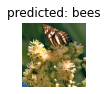

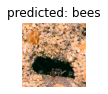

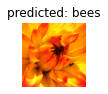

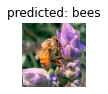

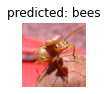

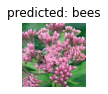

In [63]:
visualize_model(model_ft)

In [59]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [60]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=2)

Epoch0/1
----------
train Loss: 0.6041 ACC: 0.6967
val Loss: 0.2341 ACC: 0.9281

Epoch1/1
----------
train Loss: 0.4592 ACC: 0.7664
val Loss: 0.2479 ACC: 0.9216

Training compete in 1m 24s
Best val Acc: 0.9281


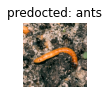

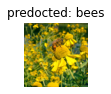

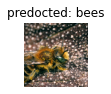

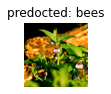

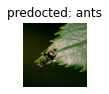

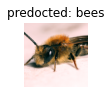

In [61]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [107]:
def eval_model(model, num_images=100):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()
  error_times = 0

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        eval_bool = True
        if preds[j] != labels[j]:
          eval_bool = False
          error_times += 1
        images_so_far += 1

        if images_so_far == num_images:
          model.train(mode=was_training)
          print('Accuracy is {}'.format((num_images - error_times) / num_images))
          return
    model.train(mode=was_training)


In [108]:
eval_model(model_conv)

Accuracy is 0.94


<Figure size 432x288 with 0 Axes>